# 2D Grid Exploration

Map grade level across a 2D grid of (α, β) coordinates to visualize where the discontinuity lives in activation space.

**Method:**
- Grid: α ∈ [-5, 5], β ∈ [-5, 5] in steps of 1.0
- Total points: 11 × 11 = 121 generations (~12 minutes on MacBook)
- Prompt: "Can you explain quantum mechanics please?"
- Measure FK grade level at each (α, β)

**Goal:** Visualize grade_level(α, β) as a heatmap. Where is the discontinuity from the 1D sweep? Is it a vertical line, a curve, or something weirder?

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Configuration

In [2]:
MODEL_NAME = "unsloth/Llama-3.2-3B-Instruct"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 27

# Grid configuration
TEST_PROMPT = "Can you explain quantum mechanics please?"
ALPHA_MIN = -5.0
ALPHA_MAX = 5.0
ALPHA_STEP = 1.0
BETA_MIN = -5.0
BETA_MAX = 5.0
BETA_STEP = 1.0

# Generation parameters
MAX_NEW_TOKENS = 200

print(f"Device: {DEVICE}")
print(f"Grid size: {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1)} × {int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} = {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1) * int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} points")

Device: cuda
Grid size: 11 × 11 = 121 points


## Load model and vectors

In [3]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: unsloth/Llama-3.2-3B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded


In [4]:
# Load vectors
vectors = torch.load('vectors/complexity_vectors.pt')
v_complexity = vectors[STEERING_LAYER]
v_perpendicular = torch.load('vectors/perpendicular_vector.pt')

print(f"V_complexity shape: {v_complexity.shape}, L2 norm: {torch.norm(v_complexity).item():.4f}")
print(f"V_perpendicular shape: {v_perpendicular.shape}, L2 norm: {torch.norm(v_perpendicular).item():.4f}")

# Verify orthogonality
dot_product = torch.dot(v_complexity, v_perpendicular).item()
print(f"Dot product (should be ~0): {dot_product}")

V_complexity shape: torch.Size([3072]), L2 norm: 9.8750
V_perpendicular shape: torch.Size([3072]), L2 norm: 9.8750
Dot product (should be ~0): 0.00066375732421875


## Steering functions

In [5]:
def generate_with_steering(prompt, alpha, beta):
    """Generate text with 2D steering: alpha * V_complexity + beta * V_perpendicular."""
    # Format prompt using chat template
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute combined steering vector
    steering_vector = (alpha * v_complexity + beta * v_perpendicular).to(model.device)
    
    # Define steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        steered = hidden_states + steering_vector.unsqueeze(0).unsqueeze(0)
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding for reproducibility
            )
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    # Extract assistant response
    if "<|start_header_id|>assistant<|end_header_id|>" in full_text:
        generated_text = full_text.split("<|start_header_id|>assistant<|end_header_id|>", 1)[1]
        generated_text = generated_text.lstrip('\n')
    else:
        generated_text = full_text[len(prompt):].strip()
    
    # Clean up special tokens
    for token in ["<|eot_id|>", "<|end_of_text|>", "<|im_end|>", "<|endoftext|>"]:
        if token in generated_text:
            generated_text = generated_text.split(token)[0]
    
    return generated_text.strip()


def analyze_text(text):
    """Compute FK grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Functions defined")

✓ Functions defined


## Run the 2D grid sweep

In [6]:
start_time = datetime.now()
print(f"Starting 2D grid sweep at {start_time.strftime('%H:%M:%S')}")
print(f"Grid: α ∈ [{ALPHA_MIN}, {ALPHA_MAX}], β ∈ [{BETA_MIN}, {BETA_MAX}]\n")

alphas = np.arange(ALPHA_MIN, ALPHA_MAX + ALPHA_STEP/2, ALPHA_STEP)
betas = np.arange(BETA_MIN, BETA_MAX + BETA_STEP/2, BETA_STEP)

results = []
total_points = len(alphas) * len(betas)
current_point = 0

for alpha in alphas:
    for beta in betas:
        current_point += 1
        print(f"[{current_point}/{total_points}] (α={alpha:+.1f}, β={beta:+.1f})...", end=" ")
        
        # Generate text
        text = generate_with_steering(TEST_PROMPT, alpha, beta)
        
        # Analyze
        metrics = analyze_text(text)
        
        # Store
        results.append({
            'alpha': alpha,
            'beta': beta,
            'generated_text': text,
            **metrics
        })
        
        print(f"GL={metrics['flesch_kincaid_grade']:.1f}")

df = pd.DataFrame(results)
end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n✓ Grid sweep complete in {elapsed:.1f} minutes")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting 2D grid sweep at 19:40:34
Grid: α ∈ [-5.0, 5.0], β ∈ [-5.0, 5.0]

[1/121] (α=-5.0, β=-5.0)... GL=48.6
[2/121] (α=-5.0, β=-4.0)... GL=37.7
[3/121] (α=-5.0, β=-3.0)... GL=34.7
[4/121] (α=-5.0, β=-2.0)... GL=49.0
[5/121] (α=-5.0, β=-1.0)... GL=49.0
[6/121] (α=-5.0, β=+0.0)... GL=48.8
[7/121] (α=-5.0, β=+1.0)... GL=48.8
[8/121] (α=-5.0, β=+2.0)... GL=49.1
[9/121] (α=-5.0, β=+3.0)... GL=49.1
[10/121] (α=-5.0, β=+4.0)... GL=49.1
[11/121] (α=-5.0, β=+5.0)... GL=43.7
[12/121] (α=-4.0, β=-5.0)... GL=15.5
[13/121] (α=-4.0, β=-4.0)... GL=15.5
[14/121] (α=-4.0, β=-3.0)... GL=26.9
[15/121] (α=-4.0, β=-2.0)... GL=49.0
[16/121] (α=-4.0, β=-1.0)... GL=49.0
[17/121] (α=-4.0, β=+0.0)... GL=48.8
[18/121] (α=-4.0, β=+1.0)... GL=42.1
[19/121] (α=-4.0, β=+2.0)... GL=25.8
[20/121] (α=-4.0, β=+3.0)... GL=26.0
[21/121] (α=-4.0, β=+4.0)... GL=42.2
[22/121] (α=-4.0, β=+5.0)... GL=43.2
[23/121] (α=-3.0, β=-5.0)... GL=17.4
[24/121] (α=-3.0, β=-4.0)... GL=7.3
[25/121] (α=-3.0, β=-3.0)... GL=9.2
[26/121] (α

## Visualize 2D heatmap

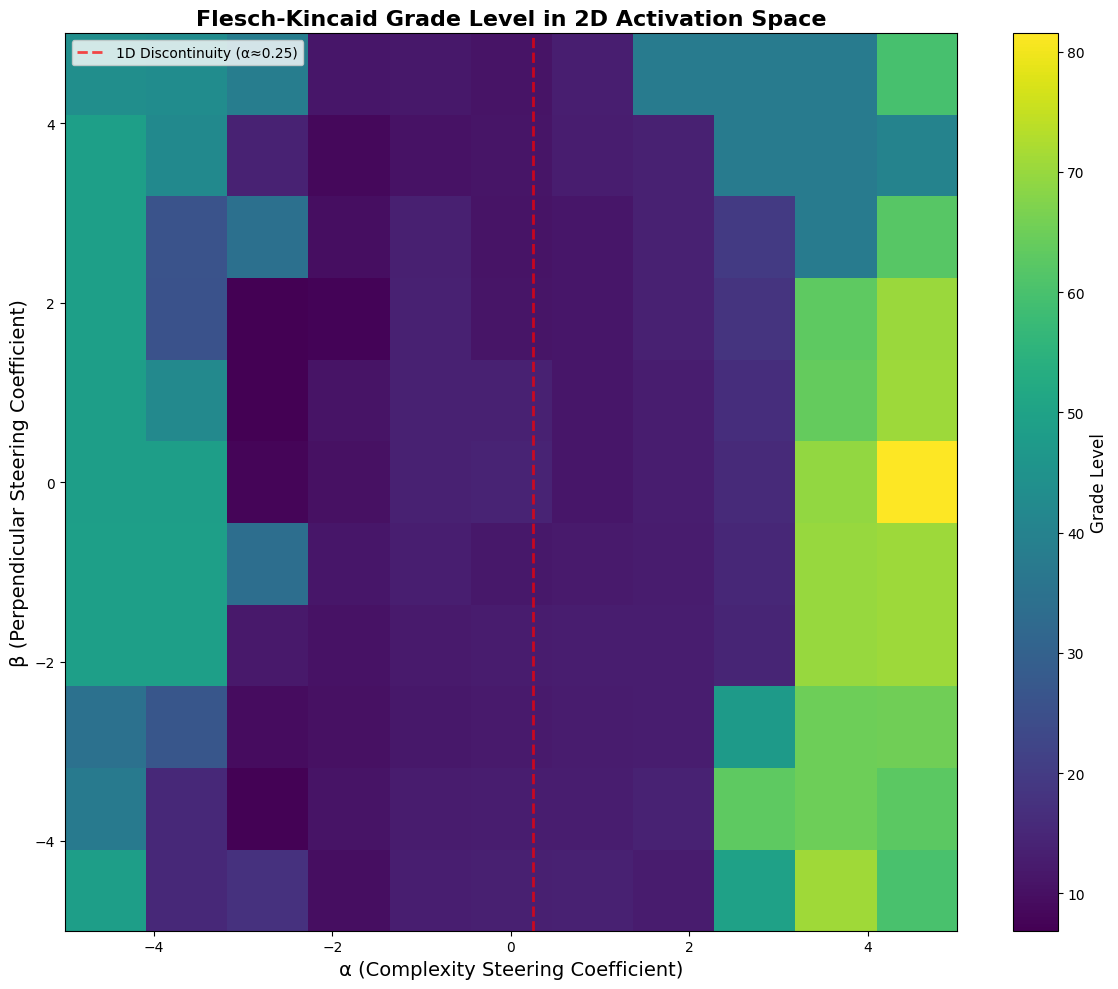


Grade level range: 6.9 to 81.5


In [7]:
# Reshape data into 2D grid for heatmap
pivot = df.pivot(index='beta', columns='alpha', values='flesch_kincaid_grade')

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(pivot, cmap='viridis', aspect='auto', origin='lower',
               extent=[ALPHA_MIN, ALPHA_MAX, BETA_MIN, BETA_MAX])

# Overlay the discontinuity from 1D data (α ≈ 0.25)
ax.axvline(0.25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1D Discontinuity (α≈0.25)')

# Labels and formatting
ax.set_xlabel('α (Complexity Steering Coefficient)', fontsize=14)
ax.set_ylabel('β (Perpendicular Steering Coefficient)', fontsize=14)
ax.set_title('Flesch-Kincaid Grade Level in 2D Activation Space', fontsize=16, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Grade Level', fontsize=12)

# Legend
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.1f} to {df['flesch_kincaid_grade'].max():.1f}")

## Save results

In [8]:
df.to_csv('data/2d_grid_results.csv', index=False)
print("✓ Saved to data/2d_grid_results.csv")

✓ Saved to data/2d_grid_results.csv
